In [1]:
import os
import sys

import itertools
import pickle
import imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

sys.path.append('../')
import utils
%matplotlib inline

In [2]:
%env CUDA_VISIBLE_DEVICES=3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

env: CUDA_VISIBLE_DEVICES=3


In [3]:
root_folder = 'tmp_results'
fixed_folder = root_folder + '/Fixed_results'

if not os.path.isdir(root_folder):
    os.mkdir(root_folder)
if not os.path.isdir(fixed_folder):
    os.mkdir(fixed_folder)

In [4]:
lr = 0.0001
latent_size = 10
batch_size = 256
train_epoch = 1000
beta = 1.0

In [5]:
mnist_train, mnist_test = utils.mnist(batch_size)

In [6]:
fixed_indxs = [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
fixed_x = torch.cat([mnist_test.dataset[i][0] for i in fixed_indxs], 0).view(10, 1, 28, 28)
fixed_x = fixed_x.repeat(1, 10, 1, 1).view(100, 1, 28, 28).to(device)
fixed_y = torch.eye(10).repeat(10, 1).to(device)

In [7]:
def show_result(num_epoch, show=False, save=False, path='result.png'):
    E.eval()
    D.eval()
    test_images = D(E(fixed_x), fixed_y).cpu()
    E.train()
    D.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(10, 10))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, :].data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    
    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        

def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    x = range(len(hist['C_losses']))

    y1 = hist['C_losses']
    y2 = hist['D_losses']

    plt.plot(x, y1, label='C_loss')
    plt.plot(x, y2, label='D_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [8]:
class Encoder(nn.Module):
    def __init__(self, output_size=10, device='cpu'):
        super(Encoder, self).__init__()
        
        conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        
        conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        
        fc1 = nn.Sequential(
            nn.Linear(7*7*32, 512),
            nn.BatchNorm1d(num_features=512),
            nn.LeakyReLU(0.2)
        )

        fc2 = nn.Sequential(
            nn.Linear(512, output_size),
            nn.LeakyReLU(0.2)
        )
        
        self.conv = nn.Sequential(
            conv1,
            conv2
        )
        
        self.fc = nn.Sequential(
            fc1,
            fc2
        )
        
        self.to(device)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 7*7*32)
        x = self.fc(x)
        return x

In [9]:
class Decoder(nn.Module):
    def __init__(self, input_size=10, device='cpu'):
        super(Decoder, self).__init__()
        
        fc1 = nn.Sequential(
            nn.Linear(input_size+10, 512),
            nn.BatchNorm1d(num_features=512),
            nn.LeakyReLU(0.2)
        )
        
        fc2 = nn.Sequential(
            nn.Linear(512, 7*7*32),
            nn.LeakyReLU(0.2)
        )
        
        conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, padding=1, stride=2),
            nn.Tanh()
        )
        
        self.fc = nn.Sequential(
            fc1,
            fc2
        )
        
        self.deconv = nn.Sequential(
            conv1,
            conv2
        )
        
        self.to(device)
        
    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        x = self.fc(x)
        x = x.view(-1, 32, 7, 7)
        x = self.deconv(x)
        return x

In [10]:
class Classifier(nn.Module):
    def __init__(self, input_size=10, device='cpu'):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, input_size*4),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(input_size*4, input_size*4),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(input_size*4, 10)
        )
        self.to(device)

    def forward(self, x):
        x = self.fc(x)
        x = F.log_softmax(x, 1)
        return x

In [11]:
# networks
E = Encoder(output_size=latent_size, device=device)
D = Decoder(input_size=latent_size, device=device)
C = Classifier(input_size=latent_size, device=device)

# losses
MSE_loss = nn.MSELoss()
NLL_loss = nn.NLLLoss()

# optimizers
E_optimizer = optim.Adam(E.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)
C_optimizer = optim.Adam(C.parameters(), lr=lr)

[1/1000]: loss_c: 2.374, loss_ae: 0.735, loss_e: 2.372


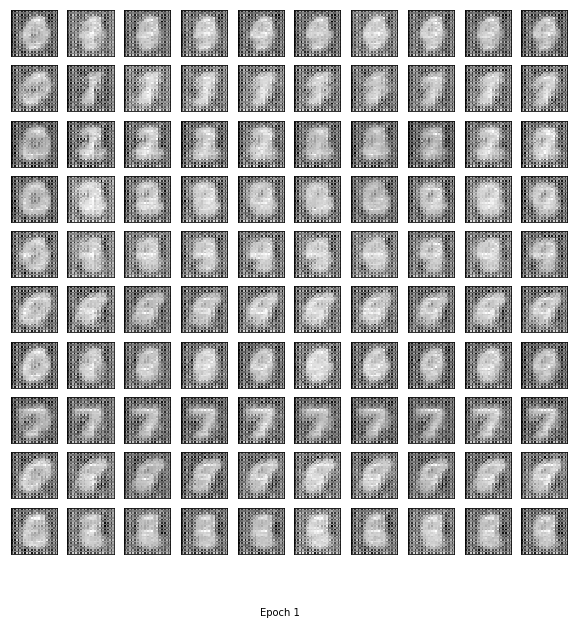

KeyboardInterrupt: 

In [12]:
train_hist = {}
train_hist['E_losses'] = []
train_hist['D_losses'] = []
train_hist['C_losses'] = []

for epoch in range(train_epoch):
    E_losses = []
    D_losses = []
    C_losses = []
    for batch_idx, (x, y) in enumerate(mnist_train):
        x = x.to(device)
        y = y.to(device)
        y_onehot = utils.to_onehot(y, 10, device)

        # train classifier C
        E.zero_grad()
        D.zero_grad()
        C.zero_grad()
        
        z = E(x)
        
        C_loss = NLL_loss(C(z), y)
        C_loss.backward(retain_graph=True)
        C_optimizer.step()

        C_losses.append(C_loss.item())
        
        # train decoder D and encoder E
        E.zero_grad()
        D.zero_grad()
        C.zero_grad()
        
        AE_loss = MSE_loss(D(z, y_onehot), x)
        C_loss = NLL_loss(C(z), y)
    
        FADER_loss = AE_loss - beta*C_loss

        FADER_loss.backward()
        D_optimizer.step()
        E_optimizer.step()
        D_losses.append(AE_loss.item())
        E_losses.append(C_loss.item())
        
    E_loss_mean = torch.mean(torch.FloatTensor(E_losses))
    D_loss_mean = torch.mean(torch.FloatTensor(D_losses))
    C_loss_mean = torch.mean(torch.FloatTensor(C_losses))
    print('[%d/%d]: loss_c: %.3f, loss_ae: %.3f, loss_e: %.3f' % (
        (epoch + 1), train_epoch, C_loss_mean, D_loss_mean, E_loss_mean))
    
    fixed_p = fixed_folder + '/MNIST_FADER_%03d.png' % (epoch+1)
    show_result((epoch+1), save=True, show=True, path=fixed_p)
    train_hist['C_losses'].append(C_loss_mean)
    train_hist['D_losses'].append(D_loss_mean)
    train_hist['E_losses'].append(E_loss_mean)
    
print("Training finish!... save training results")
torch.save(D.state_dict(), root_folder + '/decoder_param.pkl')
torch.save(C.state_dict(), root_folder + '/classifier_param.pkl')
torch.save(E.state_dict(), root_folder + '/encoder_param.pkl')